<a href="https://colab.research.google.com/github/lpires1907/griddb_nosql/blob/master/Data_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 - Data ingestion - Data Extraction

In [59]:
!pip install pycaret
!pip install --upgrade google-cloud-bigquery

In [106]:
import pandas as pd
from sklearn.decomposition import FactorAnalysis
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_selection import RFE
import altair as alt
from datetime import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import setup, compare_models, evaluate_model, predict_model



Import the file that we need to work, directly from Google Drive CSV


In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
df = pd.read_csv('/content/drive/My Drive/Accenture/Automated Insights & Gen AI Manager - Challenge Data.csv')

Example Import directly from Database Google Big Query


In [43]:
#Extract from Big Query
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

project_id = 'data-challenge-427415'
#Read the table from Big Query
from google.cloud import bigquery

client = bigquery.Client(project=project_id)

sql = """
SELECT *
FROM `data-challenge-427415.POC.POC`
"""

df = client.query(sql).to_dataframe()


Authenticated


# 2 - Data Transformation and Data Management

In [122]:
# Data Preprocessing
df['win_rate_flag_adjs'] = df['status'].apply(lambda x: 'Y' if x in ['Won', 'Lost', 'Client Withdrew', 'Accenture Withdrew'] else 'N')
df_filtered = df

pursuit_dollars = df_filtered.groupby('opp_id')['rev'].sum().reset_index()
pursuit_dollars = pursuit_dollars.rename(columns={'rev': 'Pursuit_Dollars'})
df_filtered = df_filtered.merge(pursuit_dollars, on='opp_id', how='left')

df_filtered['Won_Dollars'] = df_filtered.apply(lambda row: row['rev'] if row['status'] == 'Won' else 0, axis=1)
df_filtered['Lost_Dollars'] = df_filtered.apply(lambda row: row['rev'] if row['status'] == 'Lost' else 0, axis=1)
df_filtered['Client_Withdrew_Dollars'] = df_filtered.apply(lambda row: row['rev'] if row['status'] == 'Client Withdrew' else 0, axis=1)

df_filtered['Win_Rate'] = df_filtered['Won_Dollars'] / df_filtered['Pursuit_Dollars']

df_filtered['OpportunityCreateDt'] = pd.to_datetime(df_filtered['OpportunityCreateDt'])
df_filtered['date_final'] = pd.to_datetime(df_filtered['date_final'])
df_filtered['date_final'] = df_filtered['date_final'].fillna(datetime.now())
df_filtered['Opportunity_Time'] = (df_filtered['date_final'] - df_filtered['OpportunityCreateDt']).dt.days



In [123]:
df_filtered.head(2)

,dateid,Status Date,opp_id,status,win_rate_flag,Master_Client_Number,Client_Name,Market,MarketUnit,mu_group,...,SCCalculatorEstimatedPct,SCCalculatorSuggestedPct,PrimaryWorkLocationDesc,win_rate_flag_adjs,Pursuit_Dollars,Won_Dollars,Lost_Dollars,Client_Withdrew_Dollars,Win_Rate,Opportunity_Time
0,20180606,2018-05-31 00:00:00+00:00,1500,Unqualified,N,1230000017,AAGRPM,North America,AREA1,None,...,NaN,None,USA,N,2000.0,0.0,0.0,0.0,0.0,180
1,20180702,2018-06-30 00:00:00+00:00,1500,Unqualified,N,1230000017,AAGRPM,North America,AREA1,None,...,NaN,None,USA,N,2000.0,0.0,0.0,0.0,0.0,180


In [124]:
# prompt: Please generate a new time variable with categories of range of opportunity_time and generate a graph with Frequency and with mean of win_rate. Do the same strategy for Rev, create a new variable revenue_ range with ranges or bining of this variable.  For variables that are categories generate a frequency and a stack bar char using 'win_rate_flag_adjs' inside de bar.

import pandas as pd
import numpy as np
# Binning 'Opportunity_Time' and calculating mean win rate for each bin
df_filtered['Opportunity_Time_Range'] = pd.cut(df_filtered['Opportunity_Time'], bins=[0, 30, 60, 90, 120, np.inf],
                                               labels=['0-30', '31-60', '61-90', '91-120', '120+'])
time_range_win_rate = df_filtered.groupby('Opportunity_Time_Range')['Win_Rate'].agg(['mean', 'count']).reset_index()

# Binning 'rev' and calculating mean win rate for each bin
df_filtered['revenue_range'] = pd.cut(df_filtered['rev'], bins=[0, 100, 500, 1000, np.inf],
                                       labels=['0-100K', '100K-500K', '500K-1M', '1M+'])
revenue_range_win_rate = df_filtered.groupby('revenue_range')['Win_Rate'].agg(['mean', 'count']).reset_index()


In [94]:
df_filtered.head(2)

,dateid,Status Date,opp_id,status,win_rate_flag,Master_Client_Number,Client_Name,Market,MarketUnit,mu_group,...,PrimaryWorkLocationDesc,win_rate_flag_adjs,Pursuit_Dollars,Won_Dollars,Lost_Dollars,Client_Withdrew_Dollars,Win_Rate,Opportunity_Time,Opportunity_Time_Range,revenue_range
0,20180906,2018-08-31 00:00:00+00:00,3395,Won,Y,1230000017,AAGRPM,North America,AREA1,None,...,USA,Y,250.028,250.028,0.0,0.0,1.0,15,0-30,100K-500K
1,20180906,2018-08-31 00:00:00+00:00,2231,Client Withdrew,Y,1230000017,AAGRPM,North America,AREA1,None,...,USA,Y,400.000,0.000,0.0,400.0,0.0,281,120+,100K-500K


# 3 - Data Analysis: Discriptive Statistics and Graphs

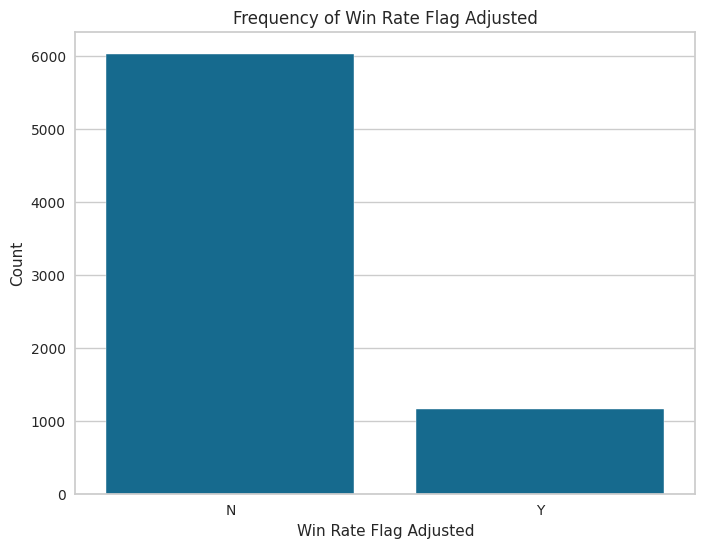

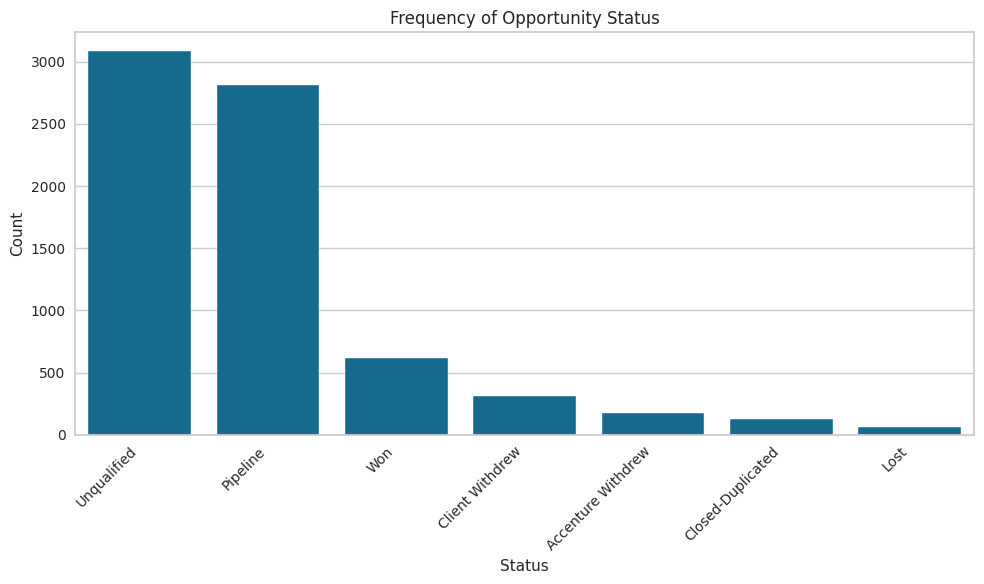

win_rate_flag_adjs,N,Y
status,,
Accenture Withdrew,0,171
Client Withdrew,0,307
Closed-Duplicated,129,0
Lost,0,63
Pipeline,2815,0
Unqualified,3083,0
Won,0,619


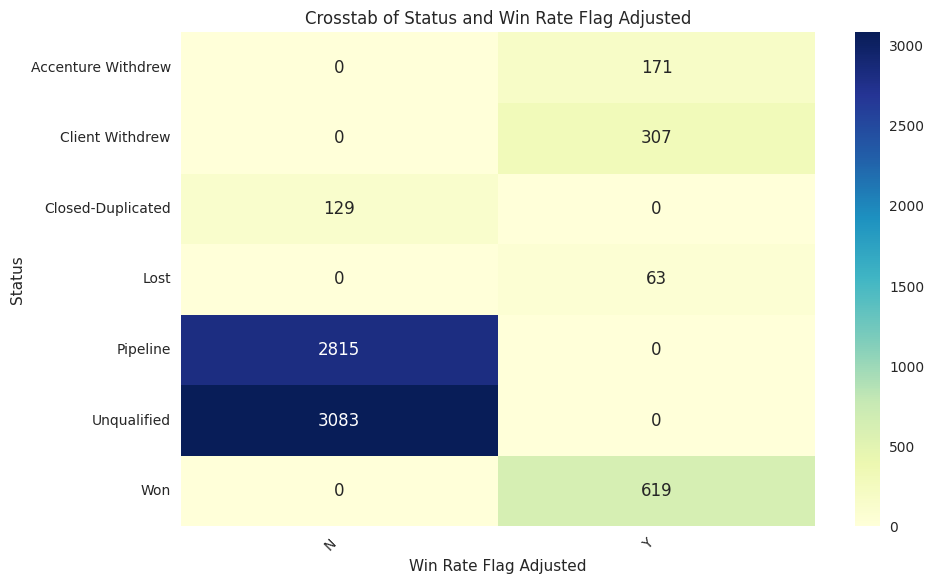

In [127]:
# prompt: generate a code to see the frequency of win_rate_flag_adjs and status, please generate a beatifull graphs and tables, do a cross tab with status on row and win_rate_flag_adjs in a column

import pandas as pd
import matplotlib.pyplot as plt
# Frequency of 'win_rate_flag_adjs'
plt.figure(figsize=(8, 6))
sns.countplot(x='win_rate_flag_adjs', data=df_filtered)
plt.title('Frequency of Win Rate Flag Adjusted')
plt.xlabel('Win Rate Flag Adjusted')
plt.ylabel('Count')
plt.show()

# Frequency of 'status'
plt.figure(figsize=(10, 6))
sns.countplot(x='status', data=df_filtered, order=df_filtered['status'].value_counts().index)
plt.title('Frequency of Opportunity Status')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Crosstab of 'status' and 'win_rate_flag_adjs'
crosstab = pd.crosstab(df_filtered['status'], df_filtered['win_rate_flag_adjs'])

# Display crosstab as a table
display(crosstab)

# Visualize crosstab with a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(crosstab, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Crosstab of Status and Win Rate Flag Adjusted')
plt.xlabel('Win Rate Flag Adjusted')
plt.ylabel('Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


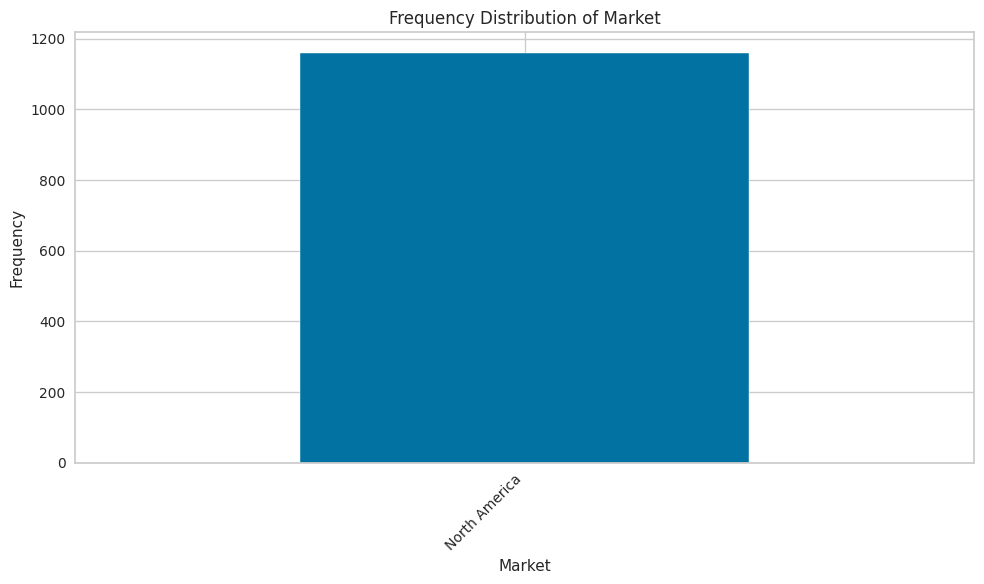

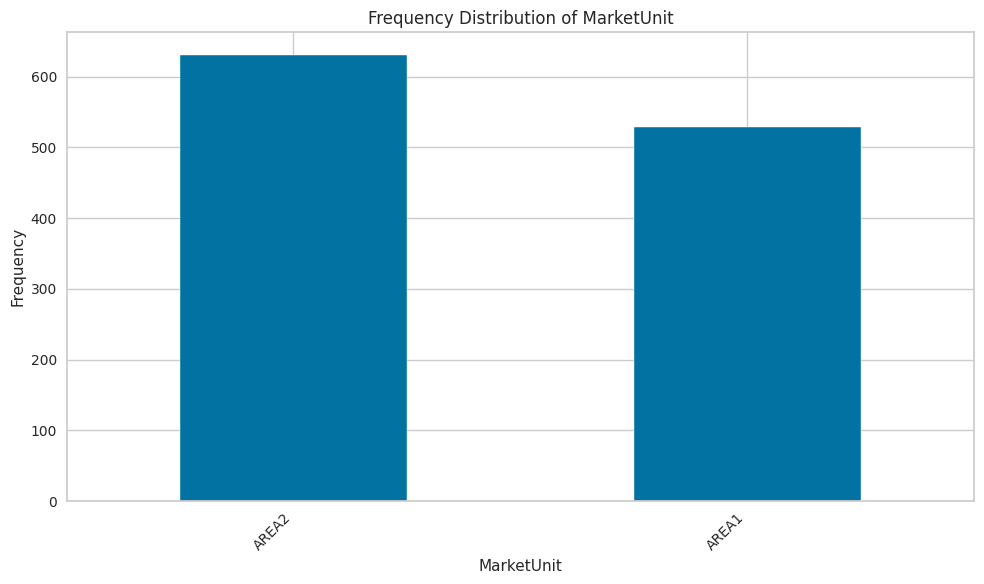

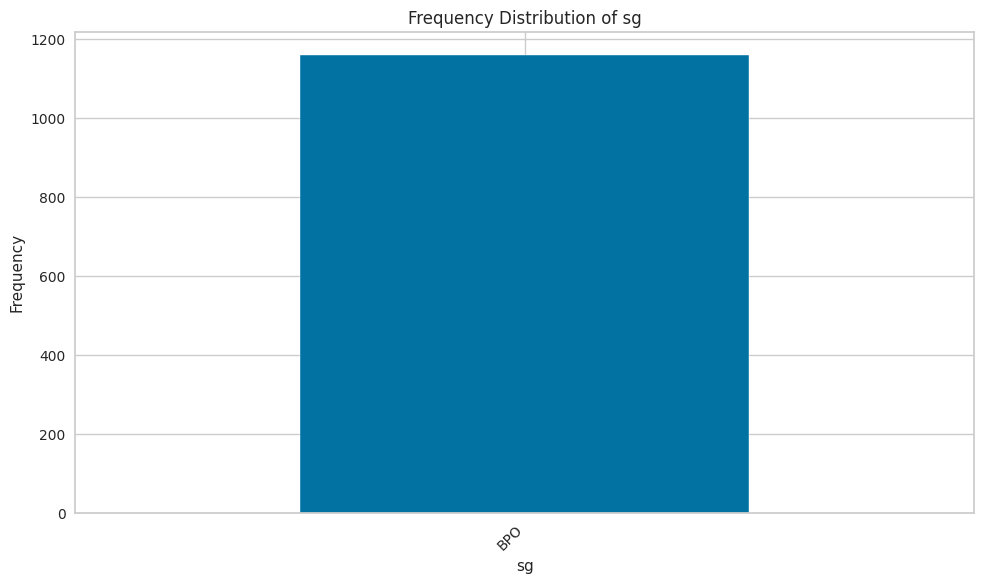

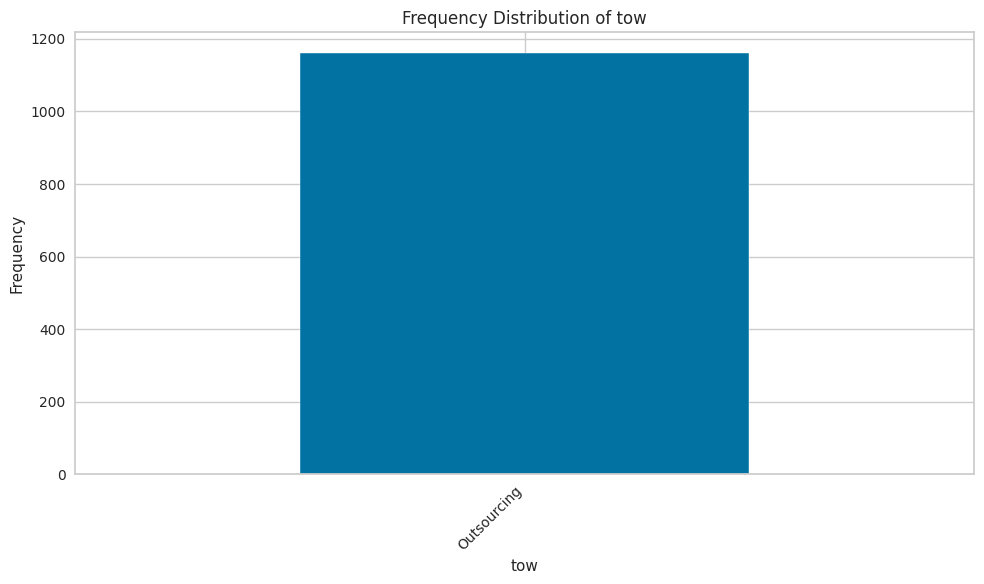

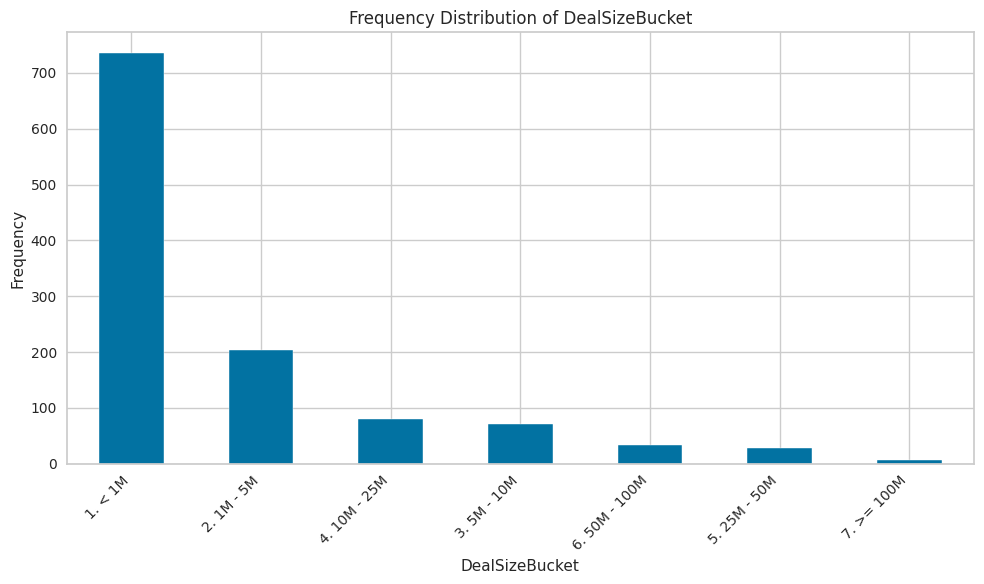

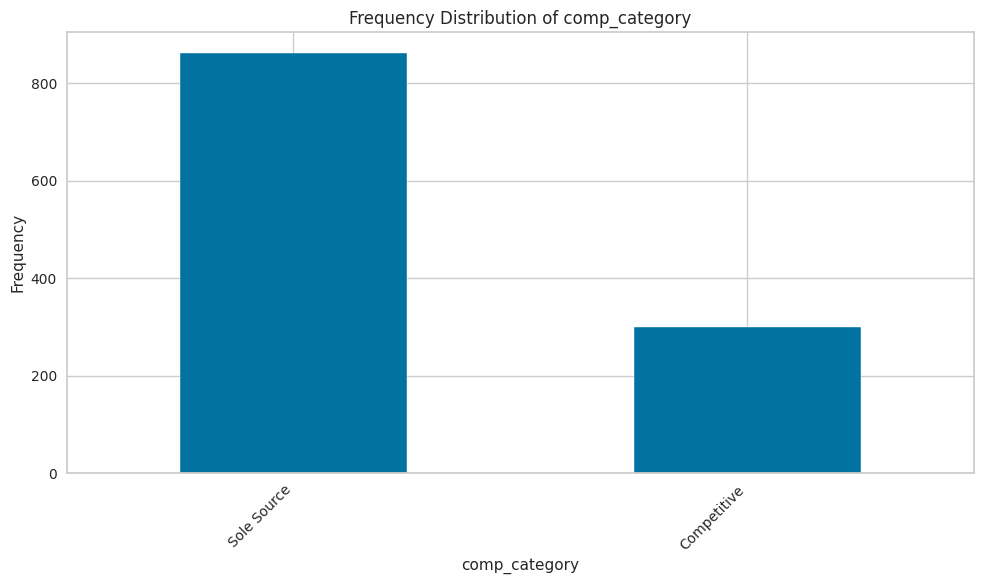

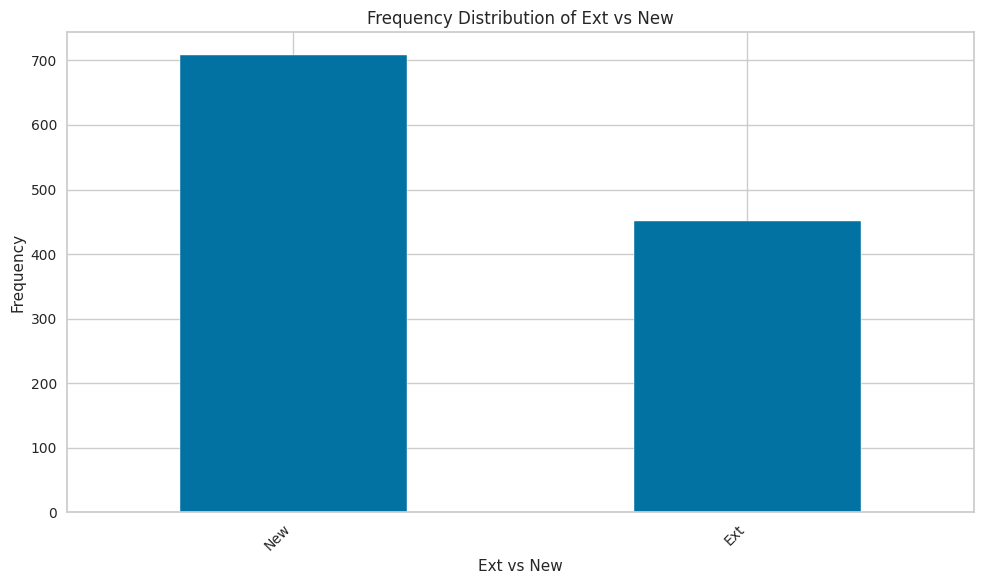

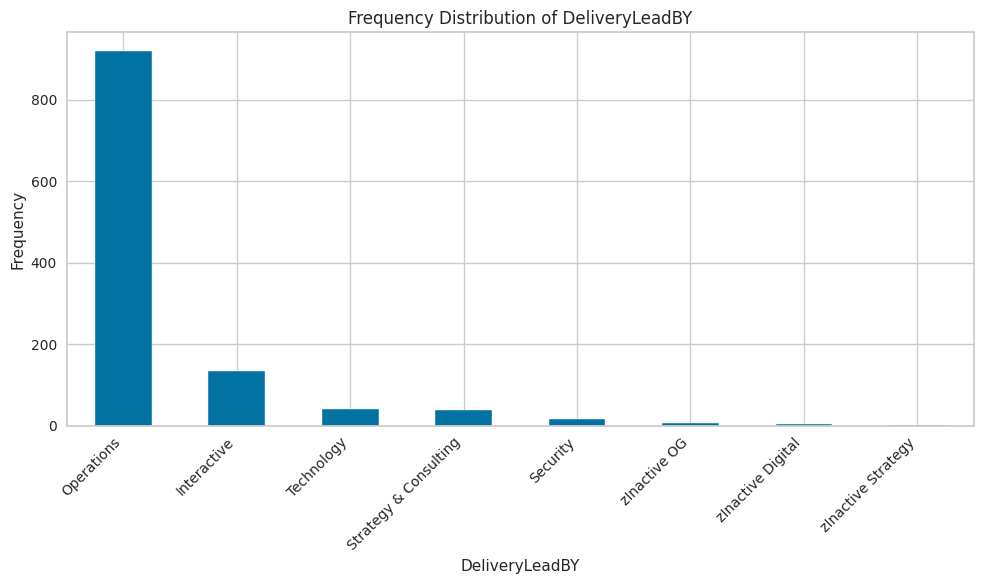

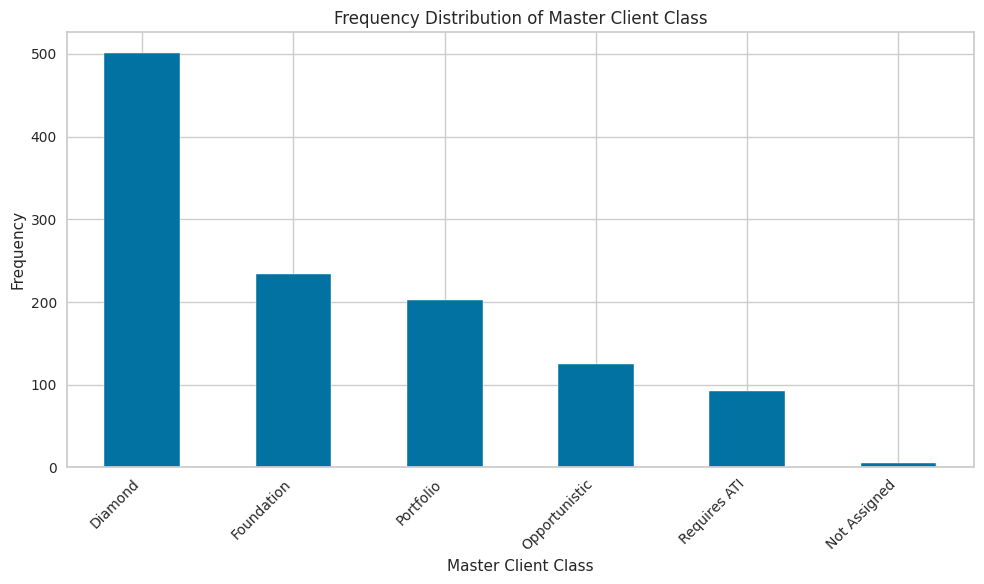

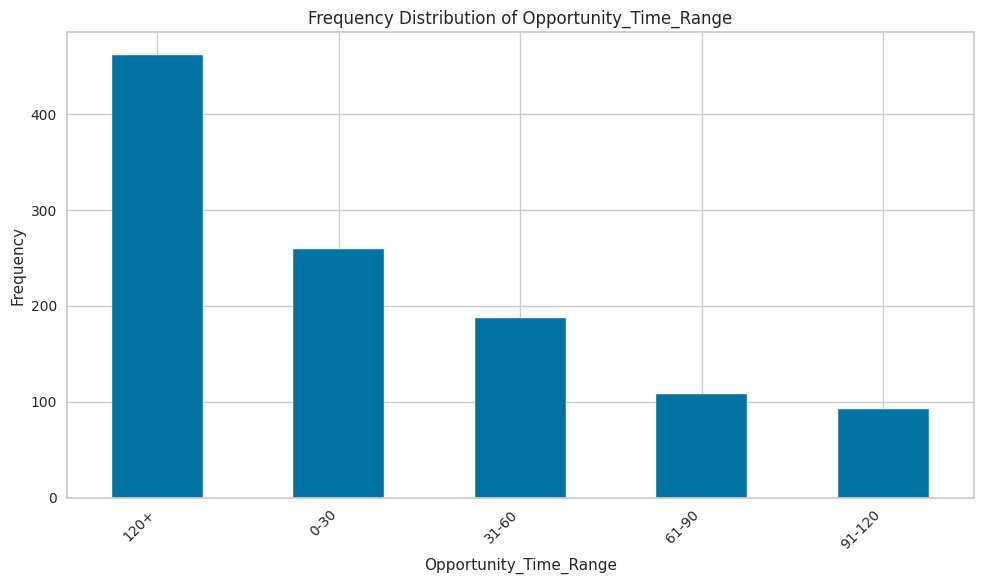

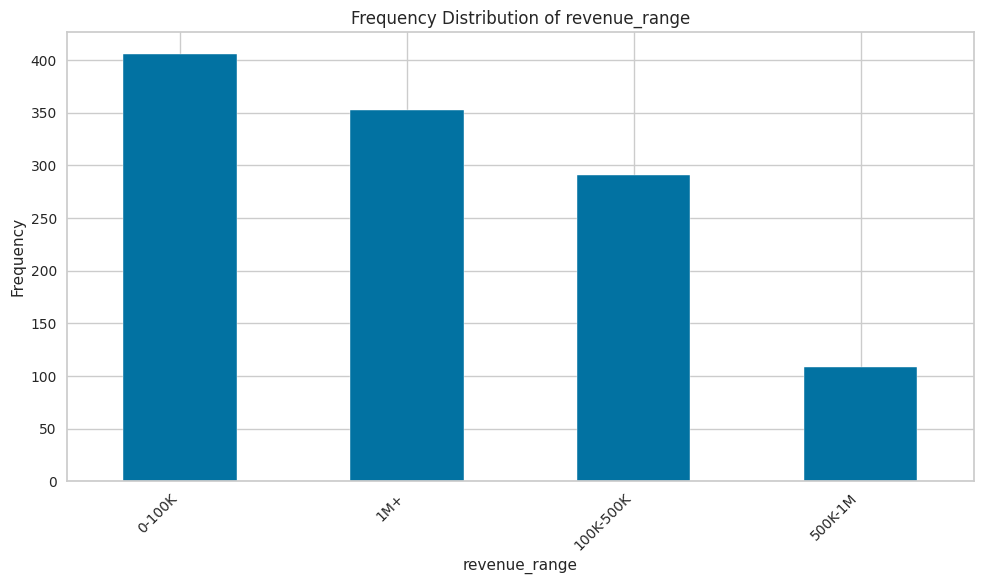

                 rev  Opportunity_Time
count    1160.000000       1160.000000
mean     3876.499351        148.134483
std     13021.756554        180.477755
min       -95.677000        -25.000000
25%        51.850000         28.000000
50%       300.000000         82.000000
75%      1950.340250        193.750000
max    232450.052000       1254.000000


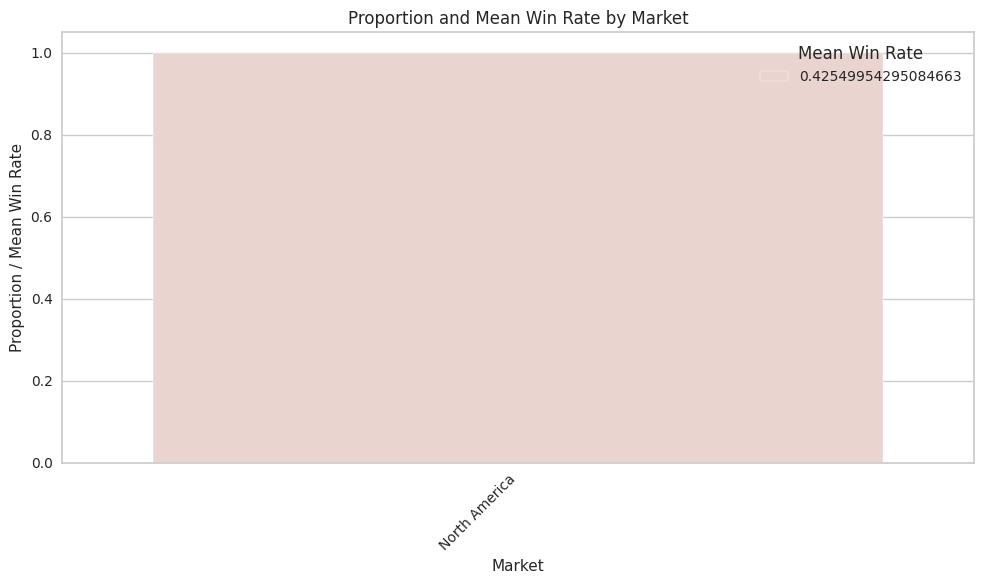

,Market,mean,count,Proportion
0,North America,42.55%,1160,100.00%


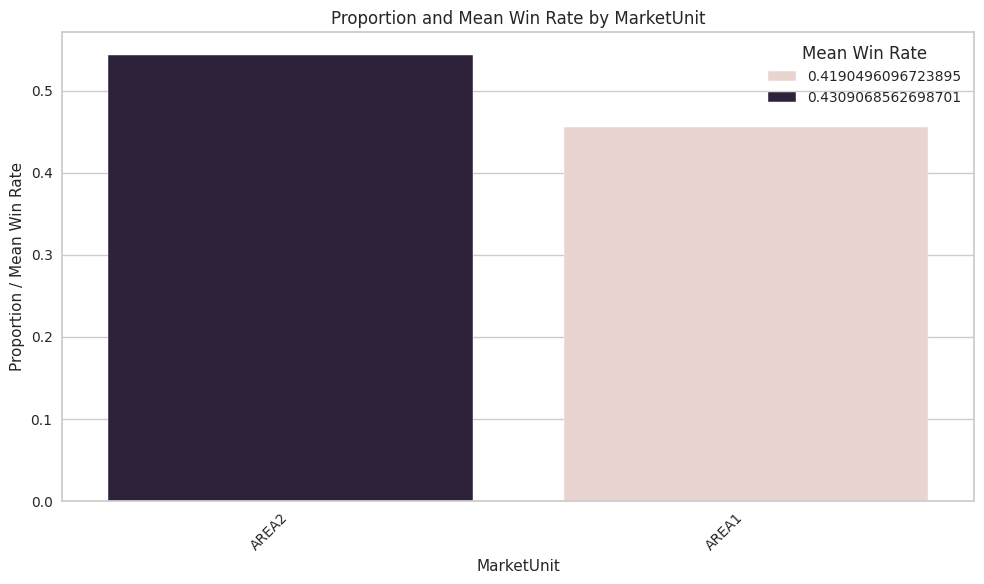

,MarketUnit,mean,count,Proportion
1,AREA2,43.09%,631,54.40%
0,AREA1,41.90%,529,45.60%


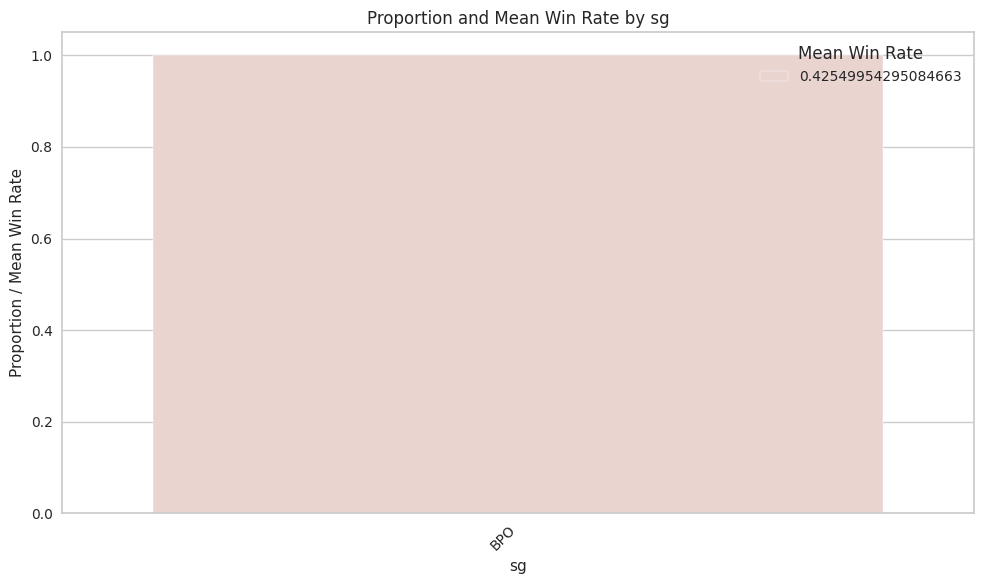

,sg,mean,count,Proportion
0,BPO,42.55%,1160,100.00%


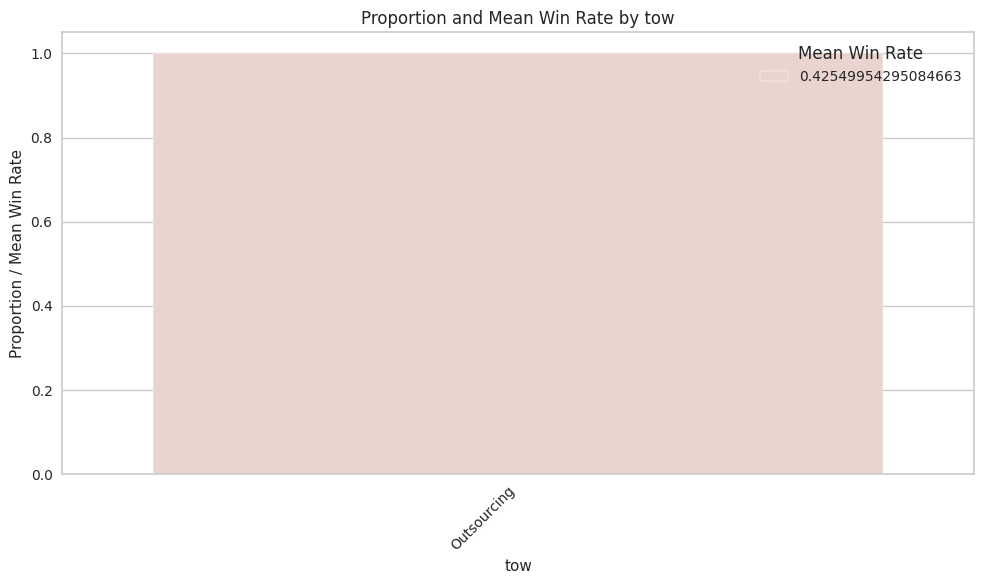

,tow,mean,count,Proportion
0,Outsourcing,42.55%,1160,100.00%


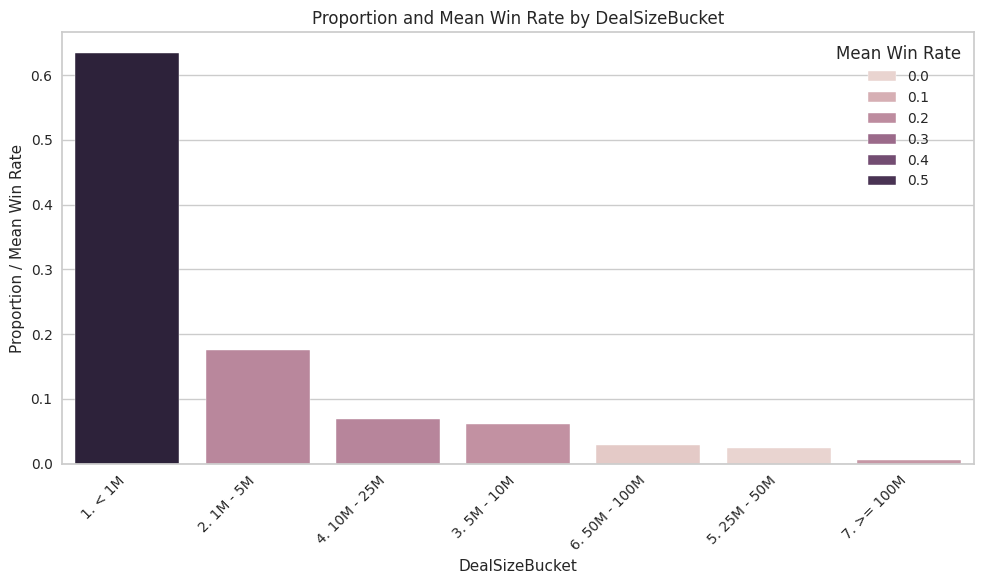

,DealSizeBucket,mean,count,Proportion
0,1. < 1M,56.72%,736,63.45%
1,2. 1M - 5M,21.11%,204,17.59%
3,4. 10M - 25M,22.04%,80,6.90%
2,3. 5M - 10M,18.59%,72,6.21%
5,6. 50M - 100M,2.94%,34,2.93%
4,5. 25M - 50M,0.00%,28,2.41%
6,7. >= 100M,16.66%,6,0.52%


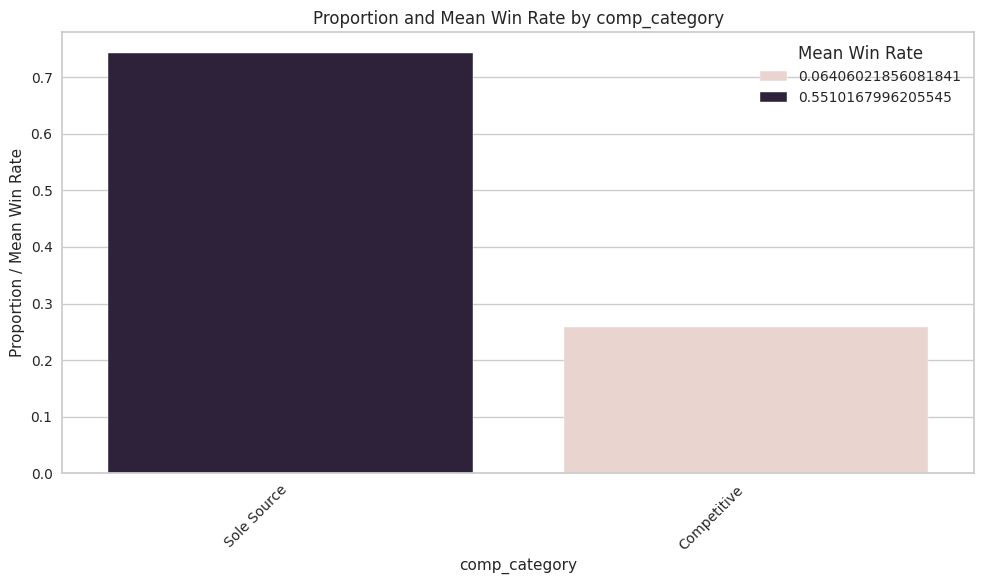

,comp_category,mean,count,Proportion
1,Sole Source,55.10%,861,74.22%
0,Competitive,6.41%,299,25.78%


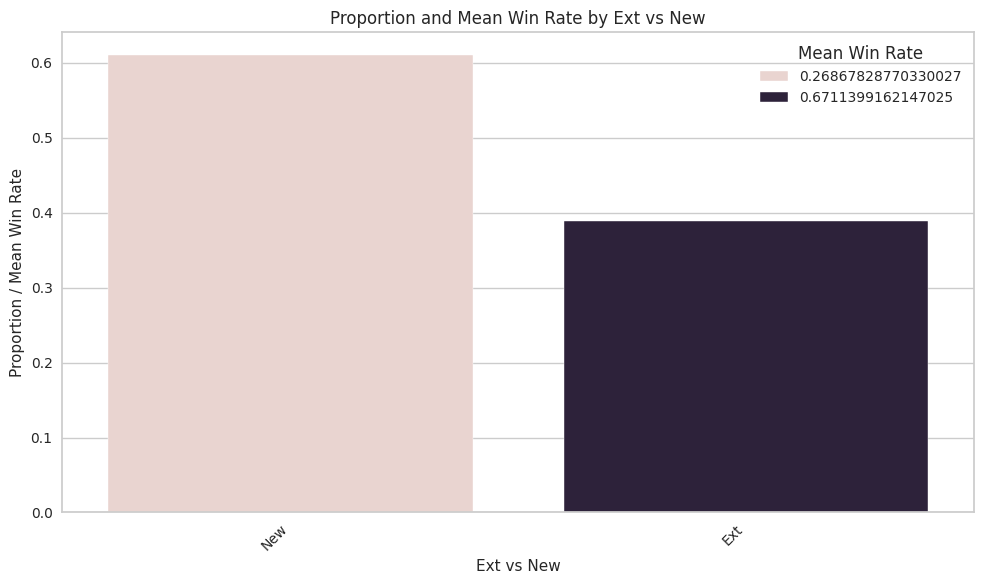

,Ext vs New,mean,count,Proportion
1,New,26.87%,708,61.03%
0,Ext,67.11%,452,38.97%


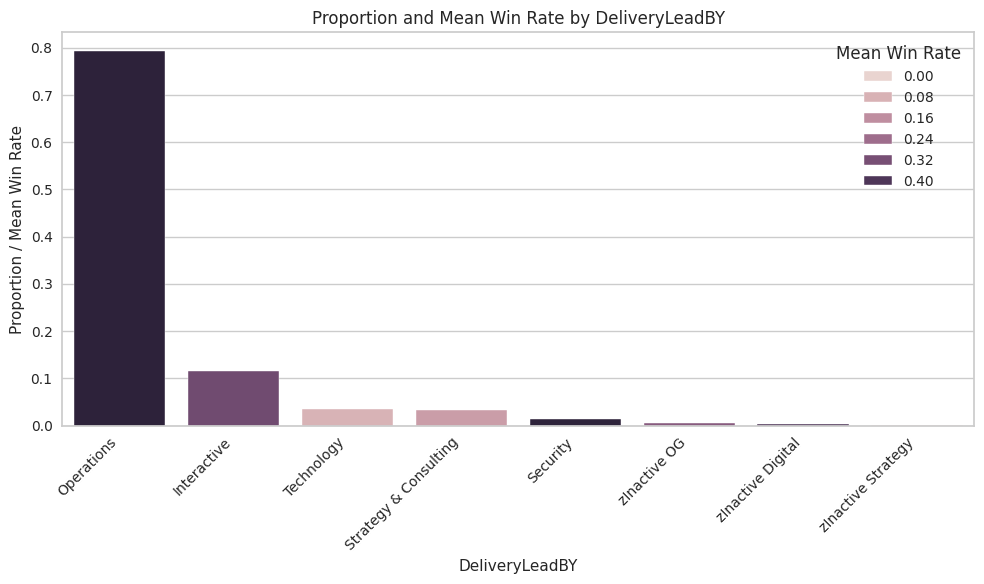

,DeliveryLeadBY,mean,count,Proportion
1,Operations,46.75%,920,79.31%
0,Interactive,33.25%,133,11.47%
4,Technology,7.50%,40,3.45%
3,Strategy & Consulting,12.59%,38,3.28%
2,Security,46.55%,16,1.38%
6,zInactive OG,28.57%,7,0.60%
5,zInactive Digital,40.00%,5,0.43%
7,zInactive Strategy,0.00%,1,0.09%


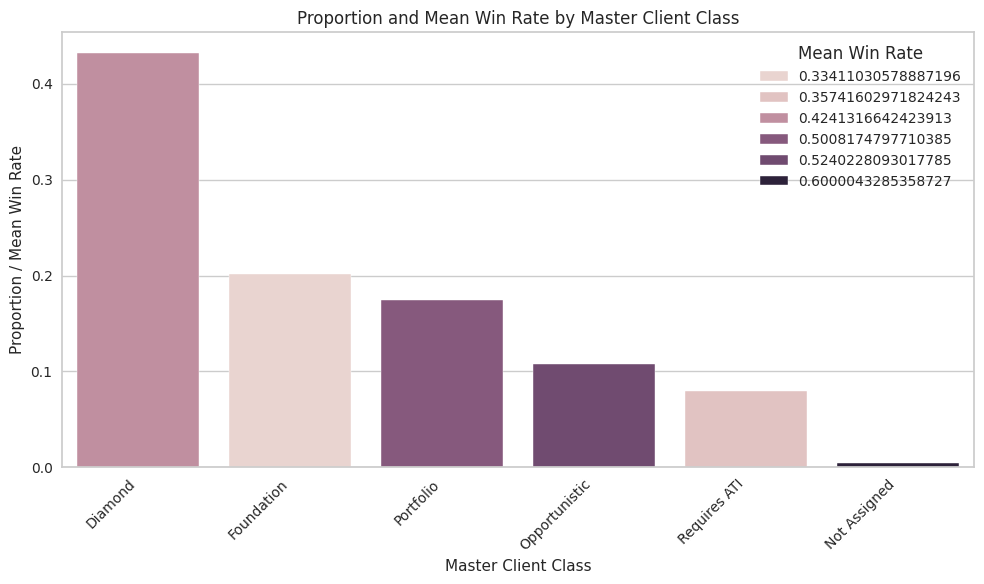

,Master Client Class,mean,count,Proportion
0,Diamond,42.41%,501,43.19%
1,Foundation,33.41%,234,20.17%
4,Portfolio,50.08%,202,17.41%
3,Opportunistic,52.40%,125,10.78%
5,Requires ATI,35.74%,93,8.02%
2,Not Assigned,60.00%,5,0.43%


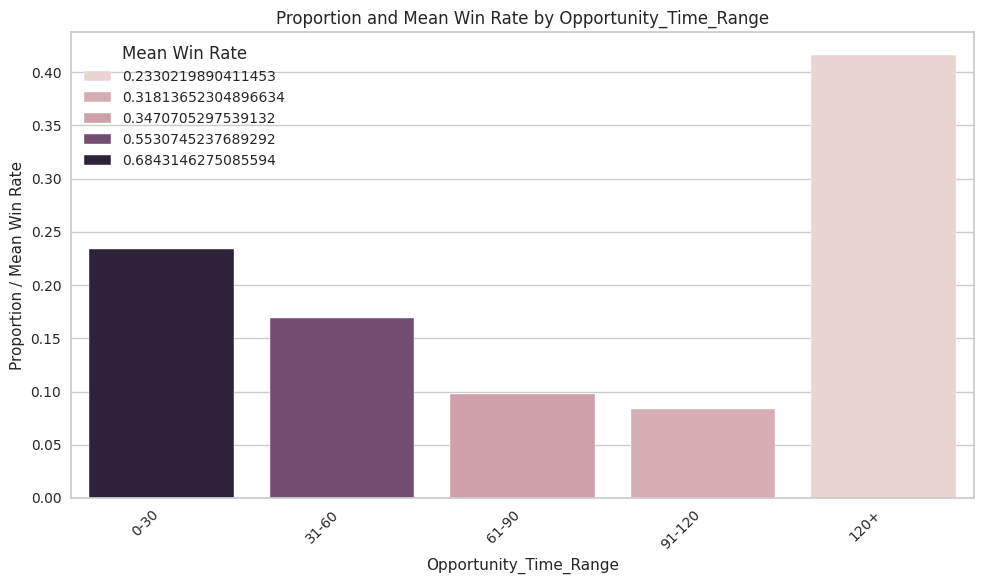

,Opportunity_Time_Range,mean,count,Proportion
4,120+,23.30%,462,41.66%
0,0-30,68.43%,259,23.35%
1,31-60,55.31%,187,16.86%
2,61-90,34.71%,108,9.74%
3,91-120,31.81%,93,8.39%


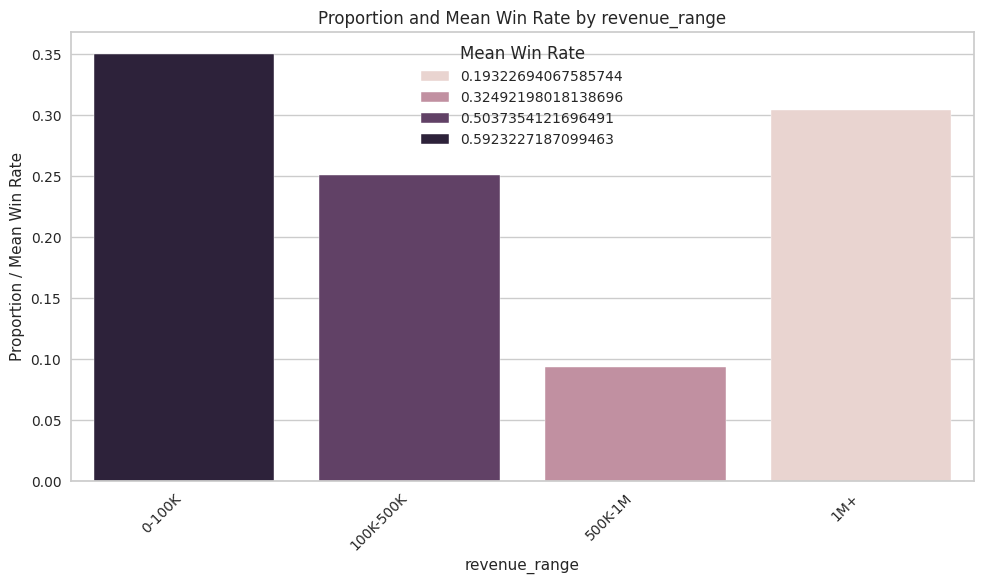

,revenue_range,mean,count,Proportion
0,0-100K,59.23%,406,35.03%
3,1M+,19.32%,353,30.46%
1,100K-500K,50.37%,291,25.11%
2,500K-1M,32.49%,109,9.40%


In [95]:

import matplotlib.pyplot as plt
# Frequency Graphs
categorical_cols = ['Market', 'MarketUnit', 'sg', 'tow', 'DealSizeBucket', 'comp_category',
                    'Ext vs New', 'DeliveryLeadBY', 'Master Client Class', 'Opportunity_Time_Range', 'revenue_range']

for col in categorical_cols:
    plt.figure(figsize=(10,6))
    df_filtered[col].value_counts().plot(kind='bar')
    plt.title(f'Frequency Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Descriptive Statistics
numerical_cols = ['rev', 'Opportunity_Time']
desc_stats = df_filtered[numerical_cols].describe()
print(desc_stats)

# Proportion Tables with Win Rate
for col in categorical_cols:
    prop_table = df_filtered.groupby(col)['Win_Rate'].agg(['mean', 'count']).reset_index()
    prop_table['Proportion'] = prop_table['count'] / prop_table['count'].sum()
    prop_table = prop_table.sort_values('Proportion', ascending=False)

    plt.figure(figsize=(10,6))
    sns.barplot(x=col, y='Proportion', data=prop_table, hue='mean')
    plt.title(f'Proportion and Mean Win Rate by {col}')
    plt.xlabel(col)
    plt.ylabel('Proportion / Mean Win Rate')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Mean Win Rate')
    plt.tight_layout()
    plt.show()

    display(prop_table.style.format({'mean': '{:.2%}', 'Proportion': '{:.2%}'}))


In [101]:
# Import the necessary module from pycaret
from pycaret.classification import setup, compare_models, evaluate_model, predict_model


#  3 - Data Analysis: Advanced Analytics - Machine Learning to Discover Features most important and  generate model to score data

,Description,Value
0,Session id,123
1,Target,Win_rate_high
2,Target type,Binary
3,Original data shape,"(1160, 15)"
4,Transformed data shape,"(1288, 35)"
5,Transformed train set shape,"(940, 35)"
6,Transformed test set shape,"(348, 35)"
7,Ignore features,2
8,Numeric features,1
9,Categorical features,11


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7364,0.8205,0.7520,0.6716,0.7053,0.4692,0.4768,0.5220
ada,Ada Boost Classifier,0.7192,0.8009,0.7633,0.6416,0.6957,0.4390,0.4467,0.5570
lda,Linear Discriminant Analysis,0.7192,0.8018,0.7603,0.6414,0.6946,0.4384,0.4455,0.5460
ridge,Ridge Classifier,0.7167,0.8018,0.7574,0.6389,0.6920,0.4335,0.4404,0.4260
lr,Logistic Regression,0.7142,0.8005,0.7603,0.6353,0.6909,0.4294,0.4371,0.9540
knn,K Neighbors Classifier,0.7056,0.7591,0.7165,0.6377,0.6733,0.4079,0.4115,0.6290
rf,Random Forest Classifier,0.7031,0.7765,0.6407,0.6544,0.6449,0.3905,0.3928,0.5720
lightgbm,Light Gradient Boosting Machine,0.6995,0.7929,0.6496,0.6479,0.6454,0.3855,0.3886,0.9450
et,Extra Trees Classifier,0.6982,0.7307,0.6408,0.6476,0.6404,0.3813,0.3846,0.6090
dt,Decision Tree Classifier,0.6662,0.6571,0.5618,0.6182,0.5860,0.3080,0.3109,0.3470


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7328,0.8105,0.7687,0.6570,0.7085,0.4646,0.4695


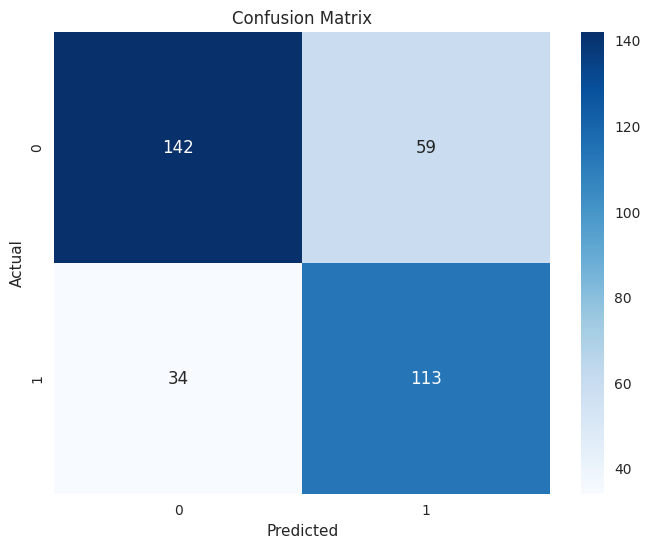

In [117]:
# prompt: Please generate a model using pycaret target binary category new variable  = 1  when Win_Rate > 0.5 and zero for other values, let the model choose ones more relevant  consider for input this list: 'MarketUnit', 'DealSizeBucket', 'comp_category',  'Ext vs New', 'DeliveryLeadBY', 'Master Client Class', 'StandaloneBundled', Opportunity_Time_Range if one variable fix still code not running


# Import the necessary module from pycaret
from pycaret.classification import setup, compare_models, evaluate_model, predict_model
# Import confusion matrix
from sklearn.metrics import confusion_matrix

# Feature Selection and Model Training with PyCaret
df_filtered_ml = df_filtered[['opp_id', 'Market', 'MarketUnit', 'sg', 'tow', 'DealSizeBucket', 'rev', 'Win_Rate',
                              'comp_category', 'Ext vs New', 'DeliveryLeadBY', 'Master Client Class',
                              'StandaloneBundled', 'Opportunity_Time_Range' ]].copy()

# Data Preprocessing

# Create a binary target variable for classification
df_filtered_ml['Win_rate_high'] = (df_filtered_ml['Win_Rate'] > 0.5).astype(int)

# Initialize PyCaret setup
clf = setup(data=df_filtered_ml, target='Win_rate_high', session_id=123,
            categorical_features=['Opportunity_Time_Range', 'Market', 'MarketUnit', 'sg', 'tow', 'DealSizeBucket', 'comp_category',
                                   'Ext vs New', 'DeliveryLeadBY', 'Master Client Class', 'StandaloneBundled'],
            ignore_features=['Win_Rate', 'opp_id'], # Since we'll create a binary target later
            normalize=True, transformation=True,
            remove_multicollinearity=True, multicollinearity_threshold=0.95,
            fix_imbalance = True # Add this to handle class imbalance
           )



# Compare models and select the best one
best_model = compare_models()

# Evaluate the best model
evaluate_model(best_model)

# Predict on test data
predictions = predict_model(best_model)

# Get the confusion matrix
cm = confusion_matrix(predictions['Win_rate_high'], predictions['prediction_label']) # Replace 'prediction_label' with the actual column name if different

# Display the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted') # Set x-axis label using plt.xlabel
plt.ylabel('Actual') # Set y-axis label using plt.ylabel
plt.title('Confusion Matrix')
plt.show()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7364,0.8205,0.7520,0.6716,0.7053,0.4692,0.4768,0.8310
ada,Ada Boost Classifier,0.7192,0.8009,0.7633,0.6416,0.6957,0.4390,0.4467,0.5660
lda,Linear Discriminant Analysis,0.7192,0.8018,0.7603,0.6414,0.6946,0.4384,0.4455,0.3430
ridge,Ridge Classifier,0.7167,0.8018,0.7574,0.6389,0.6920,0.4335,0.4404,0.3410
lr,Logistic Regression,0.7142,0.8005,0.7603,0.6353,0.6909,0.4294,0.4371,0.4260
knn,K Neighbors Classifier,0.7056,0.7591,0.7165,0.6377,0.6733,0.4079,0.4115,0.3480
rf,Random Forest Classifier,0.7031,0.7765,0.6407,0.6544,0.6449,0.3905,0.3928,0.7650
lightgbm,Light Gradient Boosting Machine,0.6995,0.7929,0.6496,0.6479,0.6454,0.3855,0.3886,0.6580
et,Extra Trees Classifier,0.6982,0.7307,0.6408,0.6476,0.6404,0.3813,0.3846,0.6690
dt,Decision Tree Classifier,0.6662,0.6571,0.5618,0.6182,0.5860,0.3080,0.3109,0.7080


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.7328,0.8105,0.7687,0.6570,0.7085,0.4646,0.4695


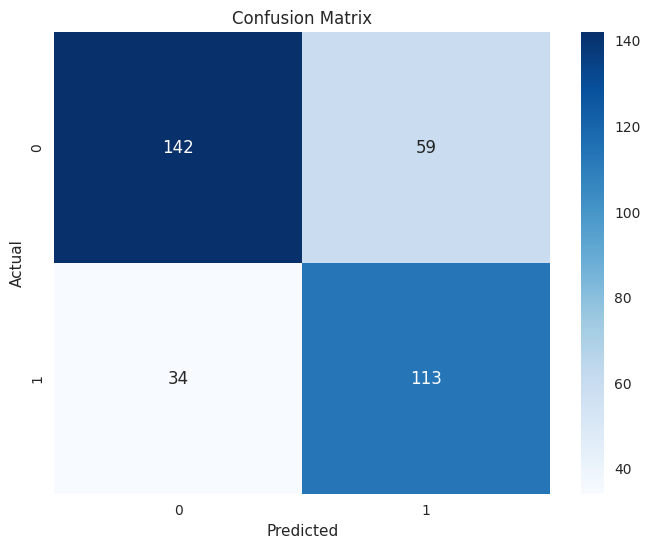

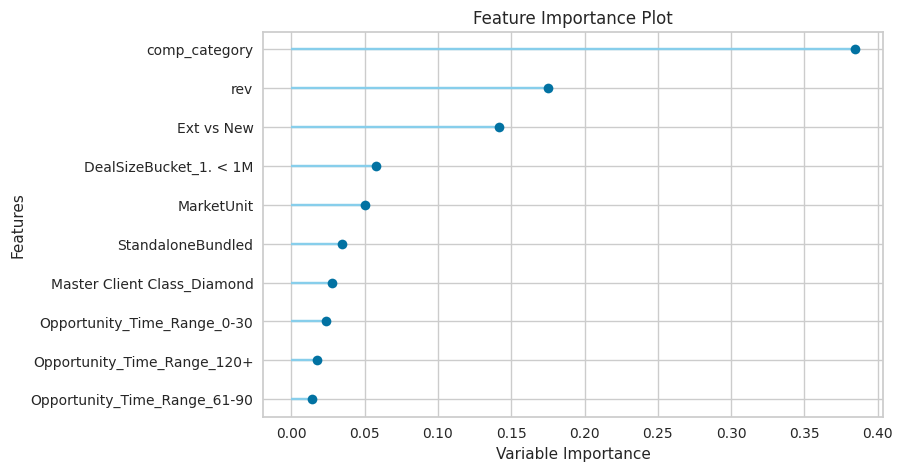

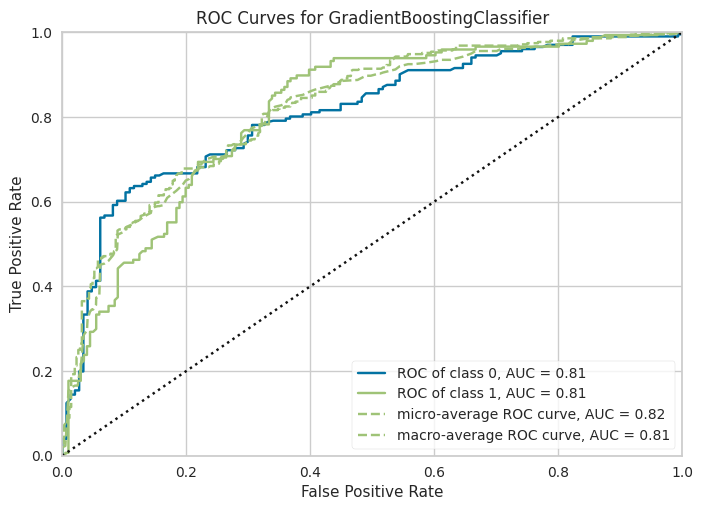

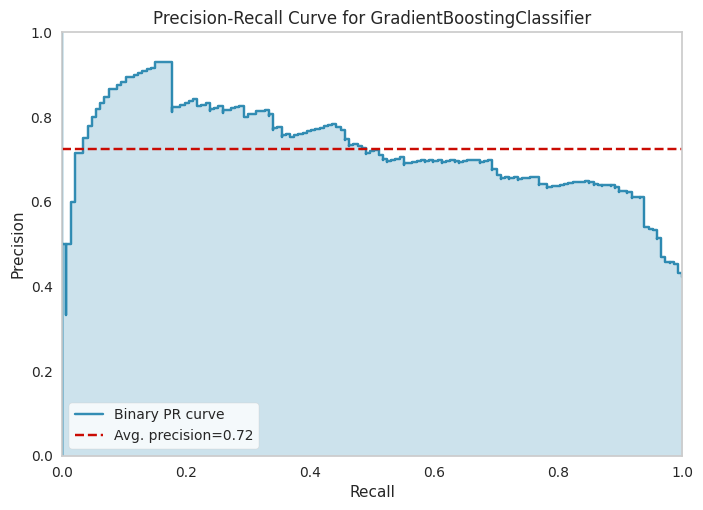

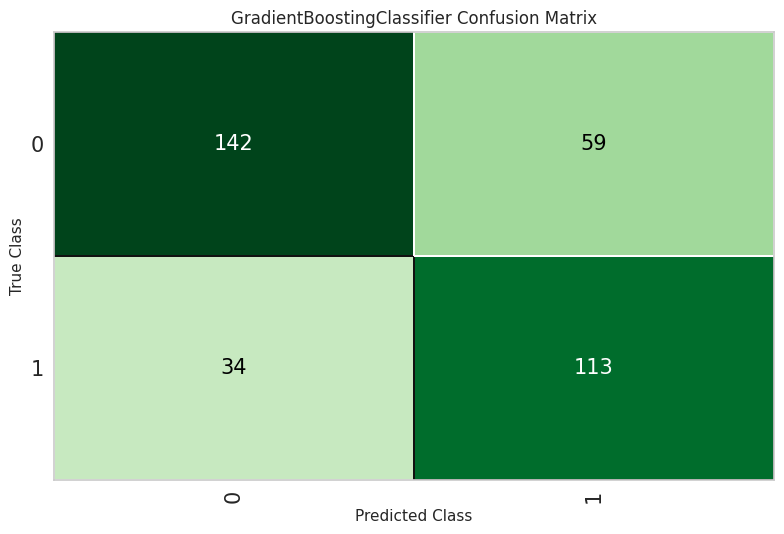

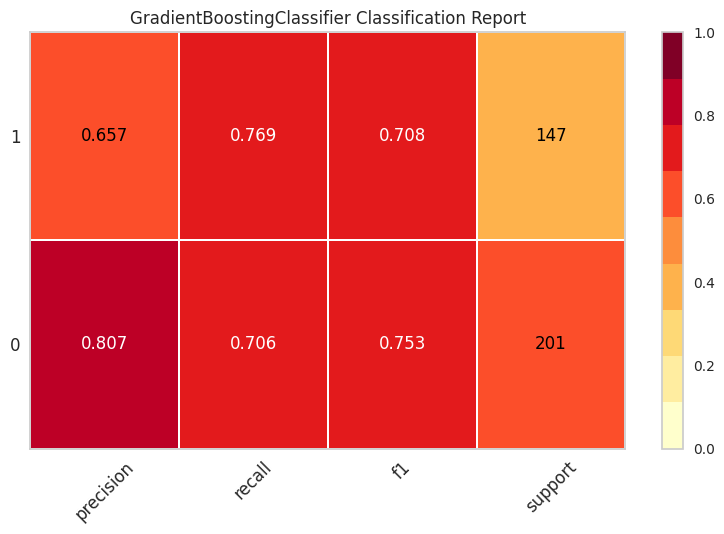

In [118]:
# prompt: generate more performance evaluation of this model, mainly the feature,  analysis to understand the most importante variables, fix this error in this code "name 'plot_model' is not defined"

import matplotlib.pyplot as plt
# Import the necessary module from pycaret
from pycaret.classification import plot_model

# ... (Your existing code) ...

# Compare models and select the best one
best_model = compare_models()

# Evaluate the best model
evaluate_model(best_model)

# Predict on test data
predictions = predict_model(best_model)

# Get the confusion matrix
cm = confusion_matrix(predictions['Win_rate_high'], predictions['prediction_label'])

# Display the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
plot_model(best_model, plot='feature')

# Other performance evaluations
plot_model(best_model, plot = 'auc')
plot_model(best_model, plot = 'pr')
plot_model(best_model, plot = 'confusion_matrix')
plot_model(best_model, plot = 'class_report')



#  3 - Data Analysis: Deployment Returning to mark all cases using best model propensity to won

In [120]:
# prompt: generate a code to return a data frame with all variables,  and all rows,  join all data in the begining variables that was excluded but that was in the previous and after used on analysis and the predictions, it didnt have predictions and Please export this results as a new table in my  GCP and as a CSV

import pandas as pd
# Get predictions with original data
predictions_with_original_data = pd.concat([df_filtered_ml.reset_index(drop=True), predictions.reset_index(drop=True)], axis=1)

# Join back the excluded columns from the original dataframe
df_with_predictions = predictions_with_original_data.merge(df_filtered.drop(columns=df_filtered_ml.columns, errors='ignore'),
                                                           left_index=True, right_index=True)

# Export to CSV
df_with_predictions.to_csv('predictions_with_all_data.csv', index=False)

# Export to BigQuery
# Replace 'your_project_id', 'your_dataset_id', and 'your_table_id' with your actual values
project_id = 'data-challenge-427415'
dataset_id = 'POC'
table_id = 'results'
# Construct the full table ID
table_ref = f"{project_id}.{dataset_id}.{table_id}"

# Load the DataFrame into BigQuery
job_config = bigquery.LoadJobConfig(
    write_disposition="WRITE_TRUNCATE",  # Overwrite the existing table
)
job = client.load_table_from_dataframe(
    df_with_predictions, table_ref, job_config=job_config
)
job.result()  # Wait for the job to complete

print(f"Loaded {df_with_predictions.shape[0]} rows and {df_with_predictions.shape[1]} columns to {table_ref}")


ValueError: Invalid call for scalar access (getting)!

In [116]:
# prompt: Please export this results as a new table in my  GCP and as a CSV

# Export to BigQuery
# Assuming 'df_filtered_ml' is the DataFrame you want to export, adjust if needed
table_id = 'data-challenge-427415.POC.results'
df_filtered_ml.to_gbq(table_id, project_id=project_id, if_exists='replace')
print(f"Results exported to BigQuery table: {table_id}")

# Export to CSV
from google.colab import files
df_filtered_ml.to_csv('results.csv', index=False)
files.download('results.csv')
print("Results downloaded as 'results.csv'")


100%|██████████| 1/1 [00:00<00:00, 712.59it/s]

Results exported to BigQuery table: data-challenge-427415.POC.results


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Results downloaded as 'results.csv'
